In [1]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=27e13ab4ed735aaf72add93e993b3a942bc363e765a553d11c9e6564c6c1660b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
# mount google drive to access/load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Input, Bidirectional, LSTM, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [4]:
# Load the dataset
def load_data(file_path):
    articles = []
    summaries = []
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            # First join words in each sentence, then join sentences in each paragraph
            article_text = ' '.join([' '.join(sentence) for paragraph in data['paragraphs'] for sentence in paragraph])
            summary_text = ' '.join([' '.join(sentence) for sentence in data['summary']])

            articles.append(article_text)
            summaries.append(summary_text)
    return articles, summaries


# Paths to one of the dataset's JSONL files (adjust for different folds)
train_file = '/content/drive/MyDrive/Dataset/indosum/train.01.jsonl'
dev_file = '/content/drive/MyDrive/Dataset/indosum/dev.01.jsonl'
test_file = '/content/drive/MyDrive/Dataset/indosum/test.01.jsonl'

# Load data
train_articles, train_summaries = load_data(train_file)
dev_articles, dev_summaries = load_data(dev_file)
test_articles, test_summaries = load_data(test_file)

In [5]:
print(f"jumlah data : {len(train_articles)}")
print(f"contoh artikel : {train_articles[0]}")
print(f"contoh summary artikel : {train_summaries[0]}")

jumlah data : 14262
contoh artikel : Jakarta , CNN Indonesia - - Dokter Ryan Thamrin , yang terkenal lewat acara Dokter Oz Indonesia , meninggal dunia pada Jumat ( 4 / 8 ) dini hari . Dokter Lula Kamal yang merupakan selebriti sekaligus rekan kerja Ryan menyebut kawannya itu sudah sakit sejak setahun yang lalu . Lula menuturkan , sakit itu membuat Ryan mesti vakum dari semua kegiatannya , termasuk menjadi pembawa acara Dokter Oz Indonesia . Kondisi itu membuat Ryan harus kembali ke kampung halamannya di Pekanbaru , Riau untuk menjalani istirahat . " Setahu saya dia orangnya sehat , tapi tahun lalu saya dengar dia sakit . ( Karena ) sakitnya , ia langsung pulang ke Pekanbaru , jadi kami yang mau jenguk juga susah . Barangkali mau istirahat , ya betul juga , kalau di Jakarta susah isirahatnya , " kata Lula kepada CNNIndonesia.com , Jumat ( 4 / 8 ) . Lula yang mengenal Ryan sejak sebelum aktif berkarier di televisi mengaku belum sempat membesuk Ryan lantaran lokasi yang jauh . Dia juga ta

In [6]:
# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_articles + train_summaries)

# Correct vocabulary size calculation
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

# Convert texts to sequences
def texts_to_sequences(texts, max_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Set max sequence lengths
max_article_len = 500
max_summary_len = 100

# Convert articles and summaries to sequences
X_train = texts_to_sequences(train_articles, max_length=max_article_len)
Y_train = texts_to_sequences(train_summaries, max_length=max_summary_len)
X_dev = texts_to_sequences(dev_articles, max_length=max_article_len)
Y_dev = texts_to_sequences(dev_summaries, max_length=max_summary_len)

Vocabulary size: 94709


In [7]:
# Prepare decoder input/output for training
Y_train_in = np.insert(Y_train, 0, 0, axis=1)[:, :-1]  # Shifted target sequences
Y_train_out = np.expand_dims(Y_train, -1)

## LSTM

In [8]:
# Define the model
embedding_dim = 128
rnn_units = 256

In [9]:
# Encoder
encoder_inputs = Input(shape=(max_article_len,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(encoder_inputs)
encoder_rnn = LSTM(rnn_units, return_sequences=False)(encoder_embedding)
encoder_output = Dense(rnn_units)(encoder_rnn)

# Decoder
decoder_inputs = Input(shape=(max_summary_len,))
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(decoder_inputs)
decoder_rnn = LSTM(rnn_units, return_sequences=True)(decoder_embedding, initial_state=[encoder_output, encoder_output])  # LSTM requires both hidden and cell states
decoder_outputs = Dense(vocab_size, activation='softmax')(decoder_rnn)

# Define the model
model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 128)       │     12,122,752 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        394,240 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 128)       │     12,122,752 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │         65,792 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 100, 256)       │        394,240 │ embedding_1[0][0],     │
│                           │                        │                │ dense[0][0],           │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 94709)     │     24,340,213 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,439,989 (188.60 MB)

 Trainable params: 49,439,989 (188.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Training
batch_size = 64

In [11]:
def create_checkpoint_callback(filename):
    return ModelCheckpoint(
        filepath=f"/content/drive/MyDrive/Model/NLP/Summarization/{filename}",
        save_weights_only=False,  # Save the entire model, not just weights
        save_best_only=False,     # Save at every epoch, not just the best one
        verbose=1                 # Print a message when saving
    )

In [13]:
history = model_lstm.fit(
    [X_train, Y_train_in],
    Y_train_out,
    batch_size=batch_size,
    epochs=10,
    validation_data=([X_dev, Y_dev], np.expand_dims(Y_dev, -1)),
    callbacks=[create_checkpoint_callback("LSTM-last-epoch.keras")]
    )

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.3945 - loss: 6.9712
Epoch 1: saving model to /content/drive/MyDrive/Model/NLP/Summarization/LSTM-last-epoch.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 202s 872ms/step - accuracy: 0.3945 - loss: 6.9656 - val_accuracy: 0.4243 - val_loss: 4.8930
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.4126 - loss: 4.8875
Epoch 2: saving model to /content/drive/MyDrive/Model/NLP/Summarization/LSTM-last-epoch.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 201s 887ms/step - accuracy: 0.4126 - loss: 4.8874 - val_accuracy: 0.4261 - val_loss: 4.8929
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.4196 - loss: 4.7695
Epoch 3: saving model to /content/drive/MyDrive/Model/NLP/Summarization/LSTM-last-epoch.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 200s 877ms/step - accuracy: 0.4196 - loss: 4.7694 - val_accuracy: 0.4174 - val_loss: 4.8792
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.4236 - loss: 4.6421
Epo

In [14]:
def compare_models_plot(histories, labels):
    if len(histories) != len(labels):
        raise ValueError("The number of histories and labels must match.")

    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        epochs = range(1, len(history.history["accuracy"]) + 1)
        plt.plot(epochs, history.history["accuracy"], label=f'Training Accuracy {label}')
        plt.plot(epochs, history.history["val_accuracy"], linestyle='--', label=f'Validation Accuracy {label}')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        epochs = range(1, len(history.history["loss"]) + 1)
        plt.plot(epochs, history.history["loss"], label=f'Training Loss {label}')
        plt.plot(epochs, history.history["val_loss"], linestyle='--', label=f'Validation Loss {label}')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

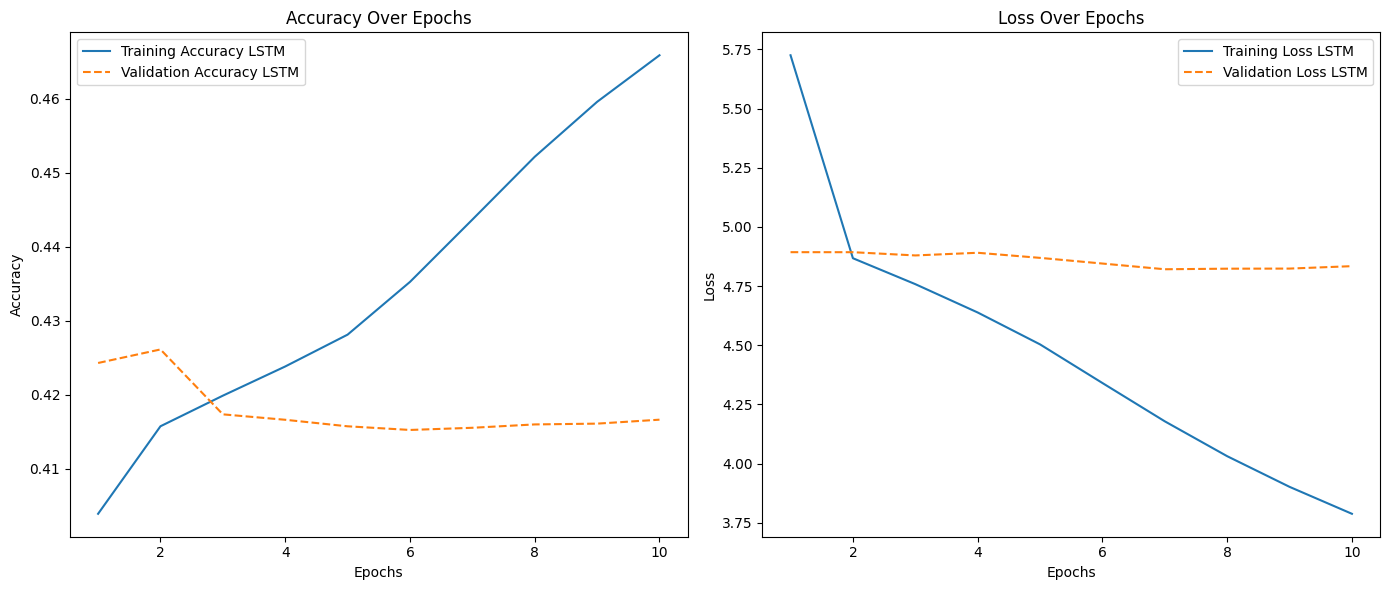

In [15]:
compare_models_plot([history], ["LSTM"])

In [22]:
# Summary generation function
def generate_summaries(X_test, model, tokenizer, max_article_len, max_summary_len):
    generated_summaries = []
    for i, article_seq in enumerate(X_test):
        article_seq = pad_sequences([article_seq], maxlen=max_article_len, padding='post')
        summary_seq = [0]  # Start token

        for _ in range(max_summary_len):
            # Predict next token
            output = model.predict([article_seq, pad_sequences([summary_seq], maxlen=max_summary_len, padding='post')], verbose=0)
            next_token = np.argmax(output[0, len(summary_seq) - 1, :])

            # Stop if the end-of-sequence or padding token is predicted
            if next_token == 0:
                break
            summary_seq.append(next_token)

        # Decode generated summary into text
        generated_summaries.append(' '.join(tokenizer.index_word.get(i, '') for i in summary_seq[1:]))
        print(f"Generated summary for article {i + 1}/{len(X_test)}")
    return generated_summaries

def decode_references(Y_test, tokenizer):
    references = []
    for seq in Y_test:
        reference = ' '.join([tokenizer.index_word.get(idx, '') for idx in seq if idx != 0])
        references.append(reference)
    return references

# Convert test articles and summaries to sequences
X_test = texts_to_sequences(test_articles[:100], max_length=max_article_len)
Y_test = texts_to_sequences(test_summaries[:100], max_length=max_summary_len)

In [18]:
# Function to compute ROUGE scores
def compute_rouge(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, cand in zip(references, candidates):
        score = scorer.score(ref, cand)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)

    # Average the scores
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_scores

In [23]:
print("Generating summaries for the test set...")
generated_summaries = generate_summaries(X_test, model_lstm, tokenizer, max_article_len, max_summary_len)
reference_summaries = decode_references(Y_test, tokenizer)

Generating summaries for the test set...
Generated summary for article 1/100
Generated summary for article 2/100
Generated summary for article 3/100
Generated summary for article 4/100
Generated summary for article 5/100
Generated summary for article 6/100
Generated summary for article 7/100
Generated summary for article 8/100
Generated summary for article 9/100
Generated summary for article 10/100
Generated summary for article 11/100
Generated summary for article 12/100
Generated summary for article 13/100
Generated summary for article 14/100
Generated summary for article 15/100
Generated summary for article 16/100
Generated summary for article 17/100
Generated summary for article 18/100
Generated summary for article 19/100
Generated summary for article 20/100
Generated summary for article 21/100
Generated summary for article 22/100
Generated summary for article 23/100
Generated summary for article 24/100
Generated summary for article 25/100
Generated summary for article 26/100
Genera

In [24]:
print(len(generated_summaries))

100


In [25]:
for i in range(0,5):
    print(f"--- Example {i+1} ---")
    print(f"Original Article: {test_articles[i][:200]}...")
    print(f"Generated Summary: {generated_summaries[i]}")
    print(f"Reference Summary: {reference_summaries[i]}")
    print()

--- Example 1 ---
Original Article: Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawa...
Generated Summary:     indonesia dan   kembali menggelar sebuah film yang digelar di indonesia pada kamis 10 8 2017 di indonesia pada kamis 10 8 malam waktu setempat di jakarta selatan pada kamis 10 8 malam waktu setempat di jakarta selatan pada kamis 10 8 2017 di jakarta selatan pada kamis 10 8 2017 di kawasan kota jakarta selatan sabtu 20 8 2017
Reference Summary: eman ahmed abd el memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di mumbai maret lalu dimana ia mengurangi seperlima dari berat badannya abd el diberi diet cairan khusus selama berada di india yang bertujuan menurunkan berat badan kini berat badannya telah turun drastis sebanyak 323 kilogram dalam tiga bulan sekarang berat badannya tinggal 176 6 kilogram

--- Examp

In [26]:
print("Evaluating ROUGE scores...")
rouge_scores = compute_rouge(reference_summaries, generated_summaries)

print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}, ROUGE-2: {rouge_scores['rouge2']:.4f}, ROUGE-L: {rouge_scores['rougeL']:.4f}")

Evaluating ROUGE scores...
ROUGE-1: 0.0758, ROUGE-2: 0.0048, ROUGE-L: 0.0611


In [27]:
def save_model_and_history(model, history, model_name, history_name):
  model.save(f"/content/drive/MyDrive/Model/NLP/Summarization/{model_name}")
  with open(f"/content/drive/MyDrive/Model/NLP/Summarization/{history_name}.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [29]:
save_model_and_history(model_lstm, history, "LSTM.keras", "LSTM_history")